### just a template copies fropm another notebook at presetn


In [1]:
from __future__ import division
import keras
import numpy as np
import pandas as pd
from utils import fx_1minute_bar_catalog, load_1minute_fx_bars, logreturn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Using TensorFlow backend.


['last_model_file', 'tl', 'epoch_count', 'dl', 'run_id']


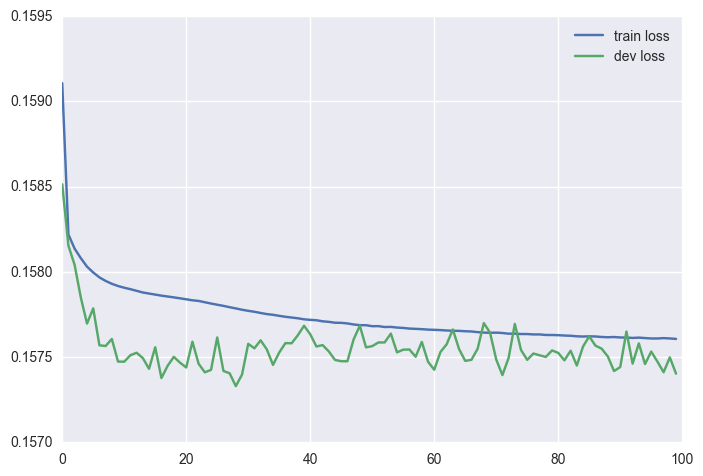

In [2]:
npz = np.load('saves/experiment_norm-price-ewma-mse-with-inverse-4x500-5cat.npz')
print npz.keys()
plt.plot(npz['tl'], label='train loss')
plt.plot(npz['dl'], label='dev loss')
plt.legend()

In [19]:
model_filename = str(npz['last_model_file'])
print model_filename

saves/model-norm-price-ewma-mse-with-inverse-4x500-5cat-100.h5


In [20]:
model = keras.models.load_model(model_filename)

In [23]:
def masig(x, lp, sp):
    volp = lp*5
    lma = x.rolling(lp).mean()
    sma = x.rolling(sp).mean()
    return np.tanh((sma - lma) * lma.rolling(volp).std() / (np.sqrt(lp) *sma.rolling(volp).std()))

def ewmasig(x, lp, sp):
    volp = lp*5
    lma = x.ewm(span=lp).mean()
    sma = x.ewm(span=sp).mean()
    return  np.tanh((sma - lma) * lma.ewm(volp).std() / (np.sqrt(lp) *sma.ewm(volp).std()))

def normalise_price(p, vol_adjust=None):
    px = logreturn(p, p.shift(1)).cumsum()
    if vol_adjust:
        px = px / ewm_vol(px, com=vol_adjust)
    return px

def ewm_vol(p,com):
    return p.diff().ewm(com, min_periods=com).std()

def add_features(px):
    df = pd.DataFrame({'px':px})
    for period in [2,4,8,16,32,64,128,256]:
        df['ret-{}'.format(period)] = np.tanh(0.33* (px - px.shift(period) )/ np.sqrt(period))
        #df['ma{}-{}'.format(2*period, period)] = masig(px, 2*period, period)
        df['ewma{}-{}'.format(2*period, period)] = ewmasig(px, 2*period, period)
    return df

def preprocess(ds):
    day = 24*60    
    px = normalise_price(ds, vol_adjust=5*day)
    df = add_features(px)
    return df


In [21]:
catalog = fx_1minute_bar_catalog()
catalog

defaultdict(list,
            {'EURGBP': ['2009',
              '2010',
              '2011',
              '2012',
              '2013',
              '2014',
              '2015',
              '2016'],
             'EURJPY': ['2009',
              '2010',
              '2011',
              '2012',
              '2013',
              '2014',
              '2015',
              '2016'],
             'EURUSD': ['2009',
              '2010',
              '2011',
              '2012',
              '2013',
              '2014',
              '2015',
              '2016'],
             'GBPCHF': ['2009',
              '2010',
              '2011',
              '2012',
              '2013',
              '2014',
              '2015',
              '2016'],
             'GBPJPY': ['2009',
              '2010',
              '2011',
              '2012',
              '2013',
              '2014',
              '2015',
              '2016'],
             'GBPUSD': ['2009',
              '

In [29]:
price = load_1minute_fx_bars('GBPJPY', 2013)['close']
ds = preprocess(price).dropna()
px = ds['px']
ds = ds.drop('px',axis=1)
ds.head(3)

,ret-2,ewma4-2,ret-4,ewma8-4,ret-8,ewma16-8,ret-16,ewma32-16,ret-32,ewma64-32,ret-64,ewma128-64,ret-128,ewma256-128,ret-256,ewma512-256
ts,,,,,,,,,,,,,,,,
2013-01-08 21:23:00,0.253812,0.325221,0.666542,0.403820,0.531702,0.226040,0.142228,0.198774,0.424274,0.293663,0.532229,0.284260,0.529395,0.175998,0.376697,0.079761
2013-01-08 21:24:00,-0.727207,-0.116052,-0.201978,0.219404,0.392179,0.187059,-0.019493,0.190940,0.311209,0.290329,0.409332,0.284433,0.480658,0.177070,0.340085,0.080462
2013-01-08 21:25:00,-0.450450,-0.154118,-0.158309,0.117607,0.278277,0.159338,0.025730,0.184629,0.266946,0.287289,0.346757,0.284646,0.504981,0.178153,0.370452,0.081168


In [30]:
ds.shape

(363870, 16)

In [31]:
%%time
pred = model.predict(ds.as_matrix())

CPU times: user 1min 21s, sys: 4.93 s, total: 1min 26s
Wall time: 34.8 s


In [35]:
fut_return = px.shift(-10) - px

In [40]:
idx = ds.index
pred

array([[ 0.26685783,  0.17271854,  0.14308982,  0.16174392,  0.25558978],
       [ 0.27185214,  0.16532236,  0.13663034,  0.15941493,  0.26678023],
       [ 0.24753934,  0.1826268 ,  0.15924111,  0.17259265,  0.2380002 ],
       ..., 
       [ 0.18889011,  0.20536509,  0.20184997,  0.21052465,  0.19337019],
       [ 0.20083508,  0.19599015,  0.19582507,  0.20121481,  0.20613484],
       [ 0.18600161,  0.20933546,  0.20159996,  0.21527721,  0.18778573]], dtype=float32)

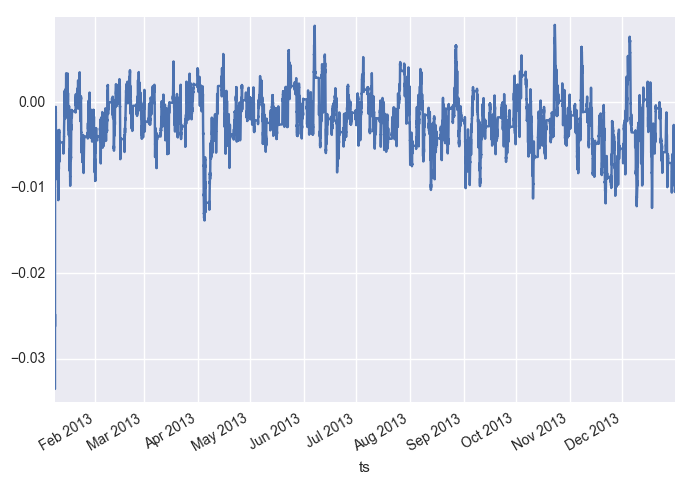

In [34]:
idx = ds.index
plt.figure()#figsize=(20,12))
pp = pd.Series((-2*pred[:,0] + -1*pred[:,1] + 1*pred[:,3] + 2*pred[:,4]), index=idx)
#pp = pd.Series((-1*pred[:,0]  + 1*pred[:,4]), index=idx)
pp.ewm(1000).mean().plot()

In [39]:
fut_return = px.shift(-10)- px
fut_return.mean()

0.041733368294290862

sig 0.0132623515416
ewma: 1 0.0124522505487
ma: 1 0.0132623515416
ewma: 2 0.011422446714
ma: 2 0.0123243129672
ewma: 3 0.0105854294256
ma: 3 0.0117863277712
ewma: 4 0.00984744593317
ma: 4 0.011417733523
ewma: 5 0.00906448837744
ma: 5 0.0105014437696
ewma: 6 0.00828391580992
ma: 6 0.0105774226795
ewma: 7 0.00782048988793
ma: 7 0.00938907391476
ewma: 8 0.00737046532823
ma: 8 0.00907800331059
ewma: 9 0.00730044888885
ma: 9 0.00878294619864


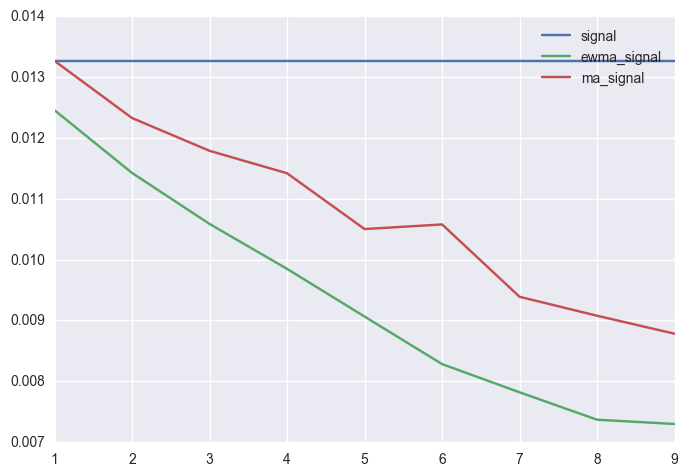

In [132]:
ewma_sx = []
ma_sx = []
sx = []
idxs = []
success = (fut_return * (((pp > 0)*2)-1)  ).mean()
print "sig", success

for i in range(1,10):
    ewma_success = (fut_return *  (((pp.ewm(i).mean() > 0)*2)-1)  ).mean()
    print "ewma:",i, ewma_success
    ewma_sx.append(ewma_success)
    ma_success = (fut_return * (((pp.rolling(i).mean() > 0)*2)-1) ).mean()
    ma_sx.append(ma_success)
    print "ma:",i, ma_success
    sx.append(success)
    idxs.append(i)
plt.plot(idxs, sx, label='signal')
plt.plot(idxs, ewma_sx, label='ewma_signal')
plt.plot(idxs, ma_sx, label='ma_signal')
plt.legend()

In [133]:
fut_return.std()

0.60575268028067963

sig 0.605608597318
ewma: 1 0.605625795875
ma: 1 0.605608597318
ewma: 2 0.605646093816
ma: 2 0.605628412884
ewma: 3 0.605661301372
ma: 3 0.60563912167
ewma: 4 0.605673749759
ma: 4 0.605646182688
ewma: 5 0.605685973447
ma: 5 0.605662763408
ewma: 6 0.605697152179
ma: 6 0.605661441257
ewma: 7 0.605703312999
ma: 7 0.605681028805
ewma: 8 0.605708956265
ma: 8 0.605685771036
ewma: 9 0.605709804203
ma: 9 0.605690121473


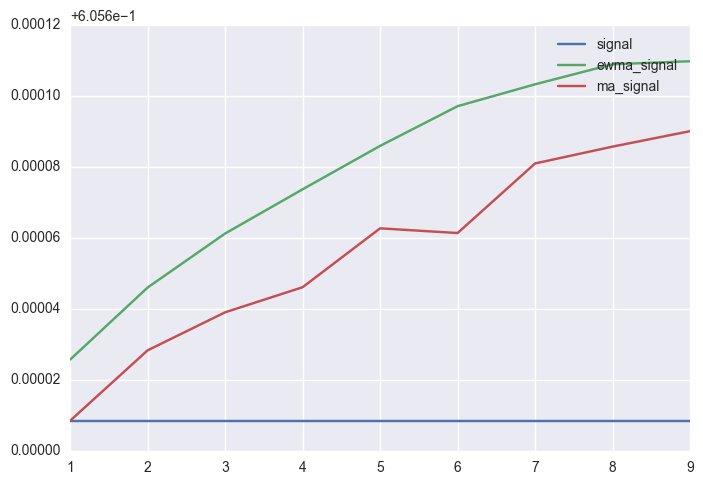

In [134]:
ewma_sx = []
ma_sx = []
sx = []
idxs = []
success = (fut_return * (((pp > 0)*2)-1)  ).std()
print "sig", success

for i in range(1,10):
    ewma_success = (fut_return *  (((pp.ewm(i).mean() > 0)*2)-1)  ).std()
    print "ewma:",i, ewma_success
    ewma_sx.append(ewma_success)
    ma_success = (fut_return * (((pp.rolling(i).mean() > 0)*2)-1) ).std()
    ma_sx.append(ma_success)
    print "ma:",i, ma_success
    sx.append(success)
    idxs.append(i)
plt.plot(idxs, sx, label='signal')
plt.plot(idxs, ewma_sx, label='ewma_signal')
plt.plot(idxs, ma_sx, label='ma_signal')
plt.legend()

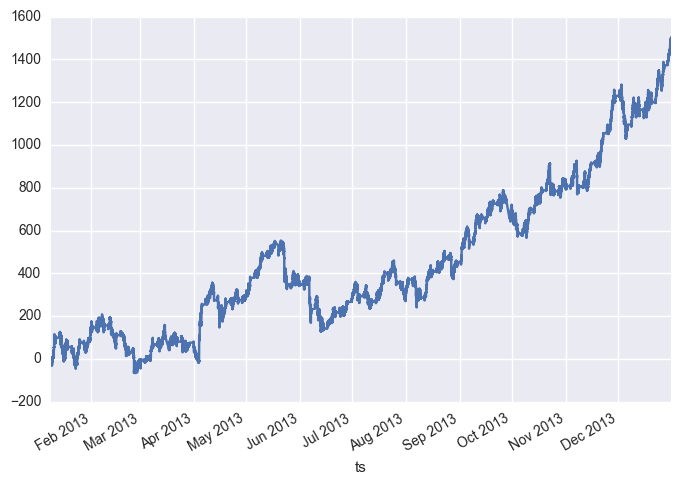

In [45]:
px.plot()

- expected return
- trading cost. frequency


In [31]:
print sx

[0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415, 0.0035138601360420415]


----------------------

In [138]:
pred.max(axis=0)

array([ 0.37622789,  0.26329806,  0.59318876,  0.26616082,  0.4128882 ], dtype=float32)

In [140]:
np.argmax(pred, axis=1)

array([2, 2, 2, ..., 2, 2, 2])

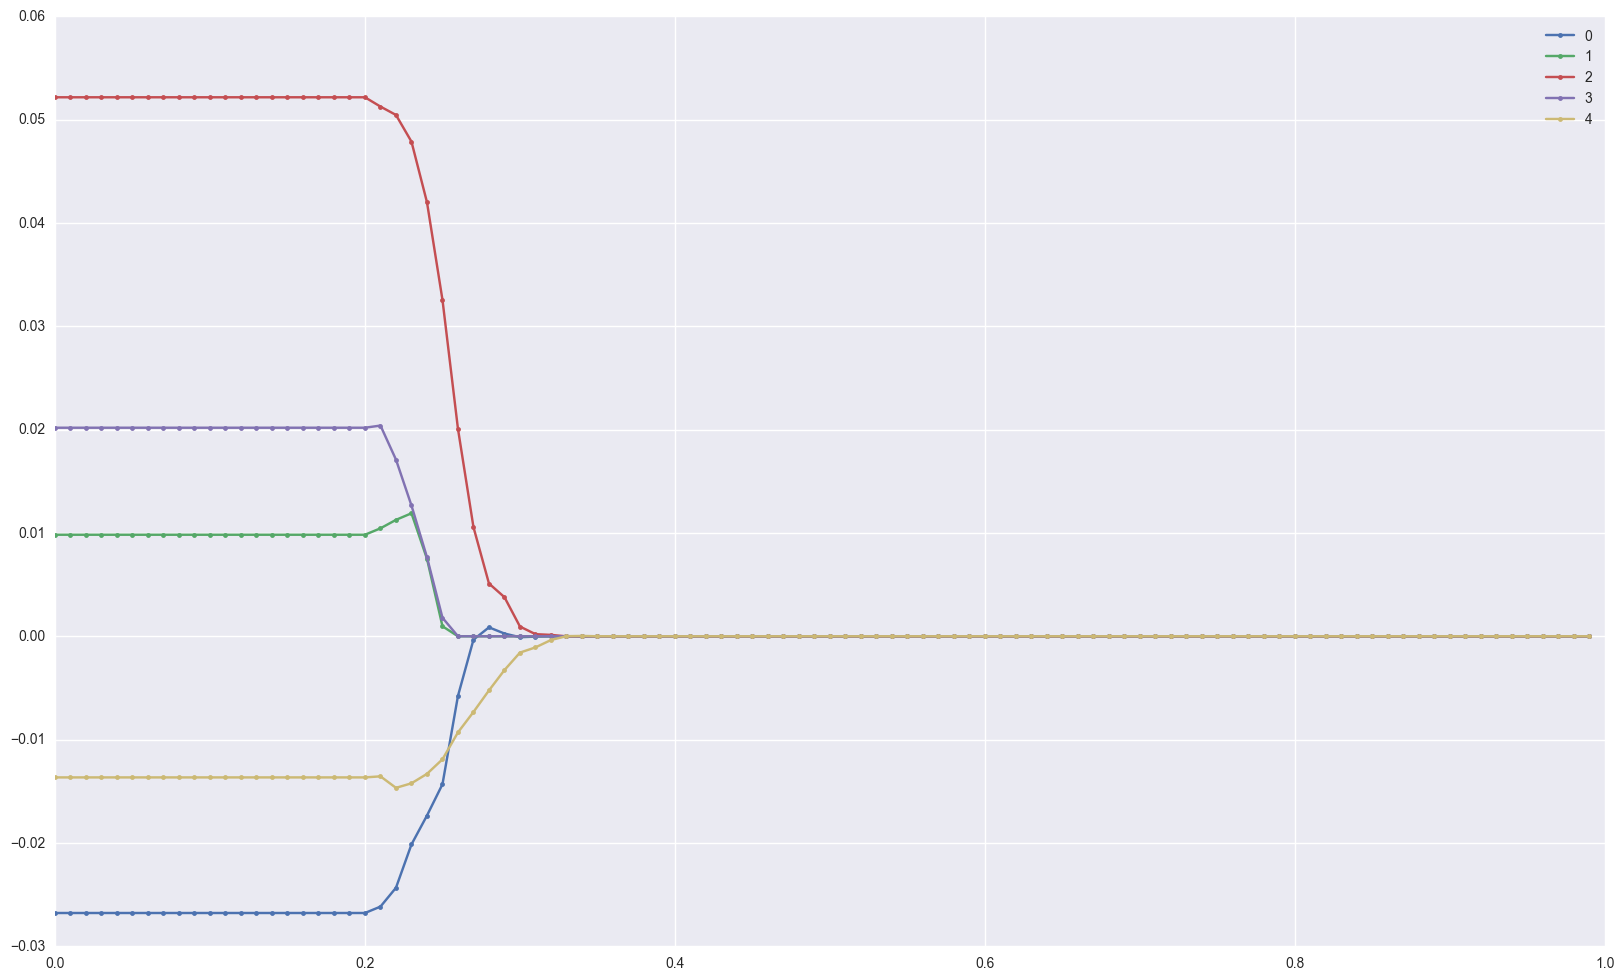

In [44]:
FIGSIZE = (20,12)
plt.figure(figsize=FIGSIZE)
STEPS = 100
for idx in range(5):
    fracs  = []
    results = []
    for i in range (STEPS):
        frac = i/STEPS
        result = ((np.argmax(pred, axis=1) == idx) * (pred[:,idx] > frac) * fut_return).mean()
        #result = ((np.argmax(pred, axis=1) == idx) *  fut_return).mean()
        fracs.append(frac)
        results.append(result)
    #print fracs, results
    plt.plot(fracs,results,'.-', label=str(idx))
plt.legend()
plt.show()
    

In [41]:
pred_categories = np.argmax(pred, axis=1)

In [42]:
for i in range(5):
    print i, 1e4*(fut_return * (pred_categories == i)).mean()

0 -267.793868206
1 98.270552811
2 521.610529005
3 201.824249999
4 -136.577780666


In [43]:
for i in range(5):
    print i, 1e4*(fut_return * (pred_categories == i)).mean()
 

0 -267.793868206
1 98.270552811
2 521.610529005
3 201.824249999
4 -136.577780666


In [154]:
INITIAL = 1000.0
RISK = 0.20
balance = INITIAL
holdings = 0
holding_period=10
countdown = 0
BPS = 1e-4
cost =10 * BPS

idx = ds.index
for i in range(len(idx)):
    prediction = pp[i]
    prx = price[i]
    amt = balance * RISK / prx

    #print i, prediction,prx
    if countdown == 0 and holdings == 0:

        if prediction > 0:
            balance -= prx *(1+cost) * amt
            holdings += amt
            #print "bought",amt,"at",prx 
        else:
            balance += prx *(1-cost)* amt
            holdings -= amt
            #print "sold",amt,"for",prx 
        countdown = holding_period
    elif countdown == 0:
        # dispose of assets if prediction opposite to current holding
        if np.sign(prediction) != np.sign(holdings):
            balance += prx * holdings
            # print "disposed of ", holdings, "at", prx,". balance=", balance
            holdings = 0
    else:
        countdown -= 1

print balance

448.289580195
